In [1]:
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import random 

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy import stats
from tqdm import tqdm

import os
import plotly.io as pio

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC


import wandb
from wandb.xgboost import WandbCallback

from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay


wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ntg2208. Use `wandb login --relogin` to force relogin


True

# EDA

In [2]:
df = pd.read_parquet("data/xgboost_data.parquet")
# df = pd.read_parquet("data/freeliving_and_trial_data.parquet")
# df = df.groupby(['user', 'date', 'day_part']).first().reset_index()
features = ['user', 'date', 'day_part', 'gender', 'ageRange', 'ethnicGroup', 'platform', 'frequency', 'duration', 'severity', 'weekday', 'cueing']
df.filter(features).sort_values(["user", "date", "day_part"]).head(12)

,user,date,day_part,gender,ageRange,ethnicGroup,platform,frequency,duration,severity,cueing
329,1r2J9taZha,2022-10-14,Afternoon,Female,55-64 years,"English, Welsh, Scottish, Northern Irish or Br...",iOS,9.0,0.0,2.0,1
0,1r2J9taZha,2022-10-14,Morning,Female,55-64 years,"English, Welsh, Scottish, Northern Irish or Br...",iOS,9.0,0.0,2.0,0
658,1r2J9taZha,2022-10-14,Night,Female,55-64 years,"English, Welsh, Scottish, Northern Irish or Br...",iOS,9.0,0.0,2.0,0
330,1r2J9taZha,2022-10-15,Afternoon,Female,55-64 years,"English, Welsh, Scottish, Northern Irish or Br...",iOS,0.0,0.0,0.0,0
1,1r2J9taZha,2022-10-15,Morning,Female,55-64 years,"English, Welsh, Scottish, Northern Irish or Br...",iOS,0.0,0.0,0.0,1
659,1r2J9taZha,2022-10-15,Night,Female,55-64 years,"English, Welsh, Scottish, Northern Irish or Br...",iOS,0.0,0.0,0.0,0
331,1r2J9taZha,2022-10-16,Afternoon,Female,55-64 years,"English, Welsh, Scottish, Northern Irish or Br...",iOS,0.0,0.0,0.0,1
2,1r2J9taZha,2022-10-16,Morning,Female,55-64 years,"English, Welsh, Scottish, Northern Irish or Br...",iOS,0.0,0.0,0.0,1
660,1r2J9taZha,2022-10-16,Night,Female,55-64 years,"English, Welsh, Scottish, Northern Irish or Br...",iOS,0.0,0.0,0.0,0
332,1r2J9taZha,2022-10-17,Afternoon,Female,55-64 years,"English, Welsh, Scottish, Northern Irish or Br...",iOS,0.0,0.0,0.0,1


In [5]:
df['user'].nunique()

25

In [79]:
fig = make_subplots(rows=2, cols=4)
df_plot = df['cueing'].value_counts().to_frame().rename_axis('gender')
display(df_plot)
# fig1 = px.bar(x = ['Male', 'Female'], y=[657, 330], 
#               title= 'gender distribution', width=400, height=400,
#               labels=dict(x="gender", y="Count"))
# fig1 = px.bar(x = ['Morning', 'Afternoon', 'Night'], y=[329, 329, 329], 
#               title= 'day_part distribution', width=400, height=400,
#               labels=dict(x="day_part", y="Count"))
# fig1 = px.bar(x = ['65+ years', '55-64 years', '45-54 years'], y=[618, 273, 96], 
#               title= 'ageRange distribution', width=400, height=400,
#               labels=dict(x="ageRange", y="Count"))
# fig1 = px.bar(x = ['English, Welsh, Scottish, Northern Irish or British', 'Irish', 'Any other ethnic group', 'No answer'], y=[753, 42, 39, 153], 
#               title= 'ethnicGroup distribution', width=400, height=400,
#               labels=dict(x="ethnicGroup", y="Count"))
# fig1 = px.bar(x = ['iOS', 'Android'], y=[657, 330],
#               title= 'platform distribution', width=400, height=400,
#               labels=dict(x="platform", y="Count"))
fig1 = px.bar(x = ['0', '1'], y=[524, 463],
              title= 'cueing distribution', width=400, height=400,
              labels=dict(x="cueing", y="Count"))
# fig2 = px.histogram(df, x='gender', barmode= 'group', color='cueing',  title= 'gender distribution by cueing class', width=400, height=400, labels=dict(color=("Yes", "No")))
# fig2 = px.histogram(df, x='ageRange', barmode= 'group', color='cueing',  title= 'ageRange distribution by cueing class', width=400, height=400, labels=dict(color=("Yes", "No")))
# fig2 = px.histogram(df, x='platform', barmode= 'group', color='cueing',  title= 'platform distribution by cueing class', width=400, height=400, labels=dict(color=("Yes", "No")))
# fig2 = px.histogram(df, x='ethnicGroup', barmode= 'group', color='cueing',  title= 'ethnicGroup distribution by cueing class', width=400, height=400, labels=dict(color=("Yes", "No")))
# fig3 = px.histogram(df, x='ageRange', barmode= 'group', color='cueing')
# fig4 = px.histogram(df, x='platform', barmode= 'group', color='cueing')
# # fig5 = px.bar(df['group'].value_counts())
fig6 = px.box(df, x='severity', color='cueing', title='severity by cueing class')
# fig7 = px.box(df, x='frequency', color='cueing')
# fig8 = px.box(df, x='severity', color='cueing')

# fig.add_trace(fig1['data'][0], row=1, col=1)
# fig.add_trace(fig2['data'][0], row=1, col=2)
# fig.add_trace(fig3['data'][0], row=1, col=3)
# fig.add_trace(fig4['data'][0], row=1, col=4)
# # fig.add_trace(fig5['data'][0], row=2, col=1)
# fig.add_trace(fig6['data'][0], row=2, col=2)
# fig.add_trace(fig7['data'][0], row=2, col=3)
# fig.add_trace(fig8['data'][0], row=2, col=4)

# fig1.update_layout(showlegend=False)
fig6.show()

,cueing
gender,
0,524
1,463


In [25]:
print(df['gender'].value_counts().to_frame().rename_axis('gender'))

        gender
gender        
Male       657
Female     330


In [4]:
df.groupby("cueing").agg({"duration": "mean", "severity": "mean", "frequency": "mean"})

,duration,severity,frequency
cueing,,,
0,30.250000,31.265267,31.362595
1,30.520518,32.526998,32.047516


In [56]:
bar_plot = df.groupby('user').first().reset_index()

fig = make_subplots(rows=1, cols=3, subplot_titles=("duration", "frequency", "severity"))
# fig1 = px.bar(bar_plot['cueing'].value_counts())
# fig2 = px.bar(bar_plot['gender'].value_counts())
# fig3 = px.bar(bar_plot['ageRange'].value_counts())
# fig4 = px.bar(bar_plot['platform'].value_counts())

fig1 = px.histogram(df, x='duration', color='cueing')
fig2 = px.histogram(df, x='frequency', color='cueing')
fig3 = px.histogram(df, x='severity', color='cueing')


fig.add_trace(fig1['data'][0], row=1, col=1)
fig.add_trace(fig2['data'][0], row=1, col=2)
fig.add_trace(fig3['data'][0], row=1, col=3)
# fig.add_trace(fig4['data'][0], row=1, col=4)

fig.update_layout(title_text='Numerics features histogram')
fig.show()

# Train

In [6]:
df = pd.read_parquet("data/xgboost_data.parquet")

df['date'] = pd.to_datetime(df['date'])
df['weekday'] = df['date'].dt.weekday
df.shape

(987, 19)

In [7]:
features = ['day_part', 'cueing', 'gender', 'ageRange', 'ethnicGroup', 'platform', 'frequency', 'duration', 'severity', 'weekday']#, 'group', 'days'] # group
data = df.filter(features)
X, y = data.drop('cueing', axis=1), data['cueing']
X.shape, y.shape

((987, 9), (987,))

In [8]:
cats = ['day_part', 'gender', 'ageRange', 'ethnicGroup', 'platform', 'group']
nums = ['days', "frequency", "duration", "severity"]

day_part_rep = {"Morning": 1, "Afternoon": 0, "Night": 2}
gender_rep = {"Male": 0, "Female": 1}
age_rep = {'45-54 years': 0, 
           '55-64 years': 1, 
           '65+ years': 2}
ethnic_rep = {'0': 0,
              'English, Welsh, Scottish, Northern Irish or British': 1, 
              'Irish': 2, 
              'Any other ethnic group': 3}
platform_rep = {'Android': 0, 'iOS': 1}
grp_rep = {'A': 0, 'B': 1}

# X['day_part'] = X['day_part'].replace(day_part_rep)
X['gender'] = X['gender'].replace(gender_rep)
X['ageRange'] = X['ageRange'].replace(age_rep)
X['ethnicGroup'] = X['ethnicGroup'].replace(ethnic_rep)
X['platform'] = X['platform'].replace(platform_rep)
# X['group'] = X['group'].replace(grp_rep)
X.head()

,day_part,gender,ageRange,ethnicGroup,platform,frequency,duration,severity,weekday
0,Morning,1,1,1,1,9.0,0.0,2.0,4
1,Morning,1,1,1,1,0.0,0.0,0.0,5
2,Morning,1,1,1,1,0.0,0.0,0.0,6
3,Morning,1,1,1,1,0.0,0.0,0.0,0
4,Morning,1,1,1,1,0.0,0.0,0.0,1


In [10]:
onehot_columns = ['day_part', 'ageRange', 'ethnicGroup']
onehot_df = X[onehot_columns]
onehot_df = pd.get_dummies(onehot_df, columns = onehot_columns)
X_onehot_drop = X.drop(onehot_columns, axis = 1)
X_onehot = pd.concat([X_onehot_drop, onehot_df], axis = 1)
X_onehot.to_clipboard()

In [14]:
# scaler = StandardScaler().set_output(transform="pandas")
# X_scaled = scaler.fit_transform(X_onehot)
seed = 8
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=test_size, random_state=seed)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((661, 16), (326, 16), (661,), (326,))

In [ ]:

def train():
    config_defaults = {
                "booster": "gbtree",
                "max_depth": 12,
                "learning_rate": 0.05,
                "subsample": 1 }
    run = wandb.init(project= "Drooling prediction", entity="ntg2208", config=config_defaults)
    config = wandb.config
    wandb.log({"Features: ": list(X_train.columns)})
    model = xgb.XGBClassifier(booster = config['booster'],learning_rate=config['learning_rate'], max_depth=config['max_depth'], \
                              subsample = config['subsample'])
    model.fit(X_train, y_train, callbacks=[WandbCallback(log_model=True)])
    y_pred = model.predict(X_test)
    cm = wandb.plot.confusion_matrix(y_true=y_test.to_list(), preds=y_pred, class_names=['no', 'yes'])
    wandb.log({"conf_mat" : cm})
    
    # print(confusion_matrix(y_test, y_pred))

    # print(classification_report(y_test, y_pred))
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.0%}")
    wandb.log({"accuracy": accuracy})

In [ ]:
sweep_config = {
    "method": "random", # try grid or random
    "metric": {
      "name": "accuracy",
      "goal": "maximize"   
    },
    "parameters": {
        "booster": {
            "values": ["gbtree"]
        },
        "max_depth": {
            "values": [3, 6, 9, 12]
        },
        "learning_rate": {
            "values": [0.1, 0.05, 0.2]
        },
        "subsample": {
            "values": [1, 0.5, 0.3]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="Drooling prediction")

In [ ]:
wandb.agent(sweep_id, train, count=30)
wandb.finish()

In [15]:



config_defaults = {
            "booster": "gbtree",
            "max_depth": 9,
            "learning_rate": 0.05,
            "subsample": 1 }
run = wandb.init(project= "Drooling prediction", entity="ntg2208", config=config_defaults, reinit=True)
config = wandb.config

model = xgb.XGBClassifier(booster = config['booster'],learning_rate=config['learning_rate'], max_depth=config['max_depth'], \
                            subsample = config['subsample'])
wandb.log({"Features: ": list(X_train.columns)})
# model = make_pipeline(StandardScaler(), SVC(kernel =  'rbf',gamma='scale'))
model.fit(X_train, y_train, callbacks=[WandbCallback(log_model=True)])
# model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report
# cm = wandb.plot.confusion_matrix(y_true=y_test.to_list(), preds=y_pred, class_names=['no', 'yes'])
# wandb.log({"conf_mat" : cm})

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.0%}")
wandb.log({"accuracy": accuracy})
run.finish()

[[120  54]
 [ 59  93]]
              precision    recall  f1-score   support

           0       0.67      0.69      0.68       174
           1       0.63      0.61      0.62       152

    accuracy                           0.65       326
   macro avg       0.65      0.65      0.65       326
weighted avg       0.65      0.65      0.65       326

Accuracy: 65%


accuracy,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
accuracy,0.65337
epoch,99


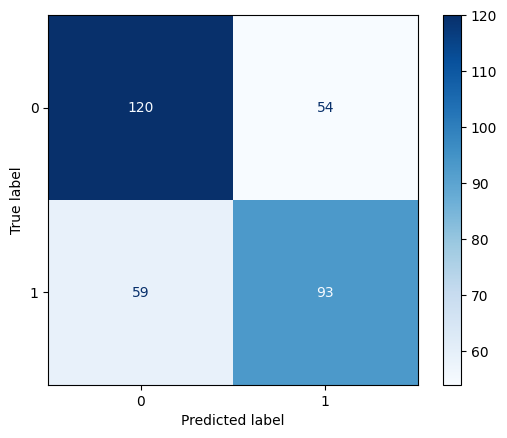

In [16]:

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot(cmap="Blues")

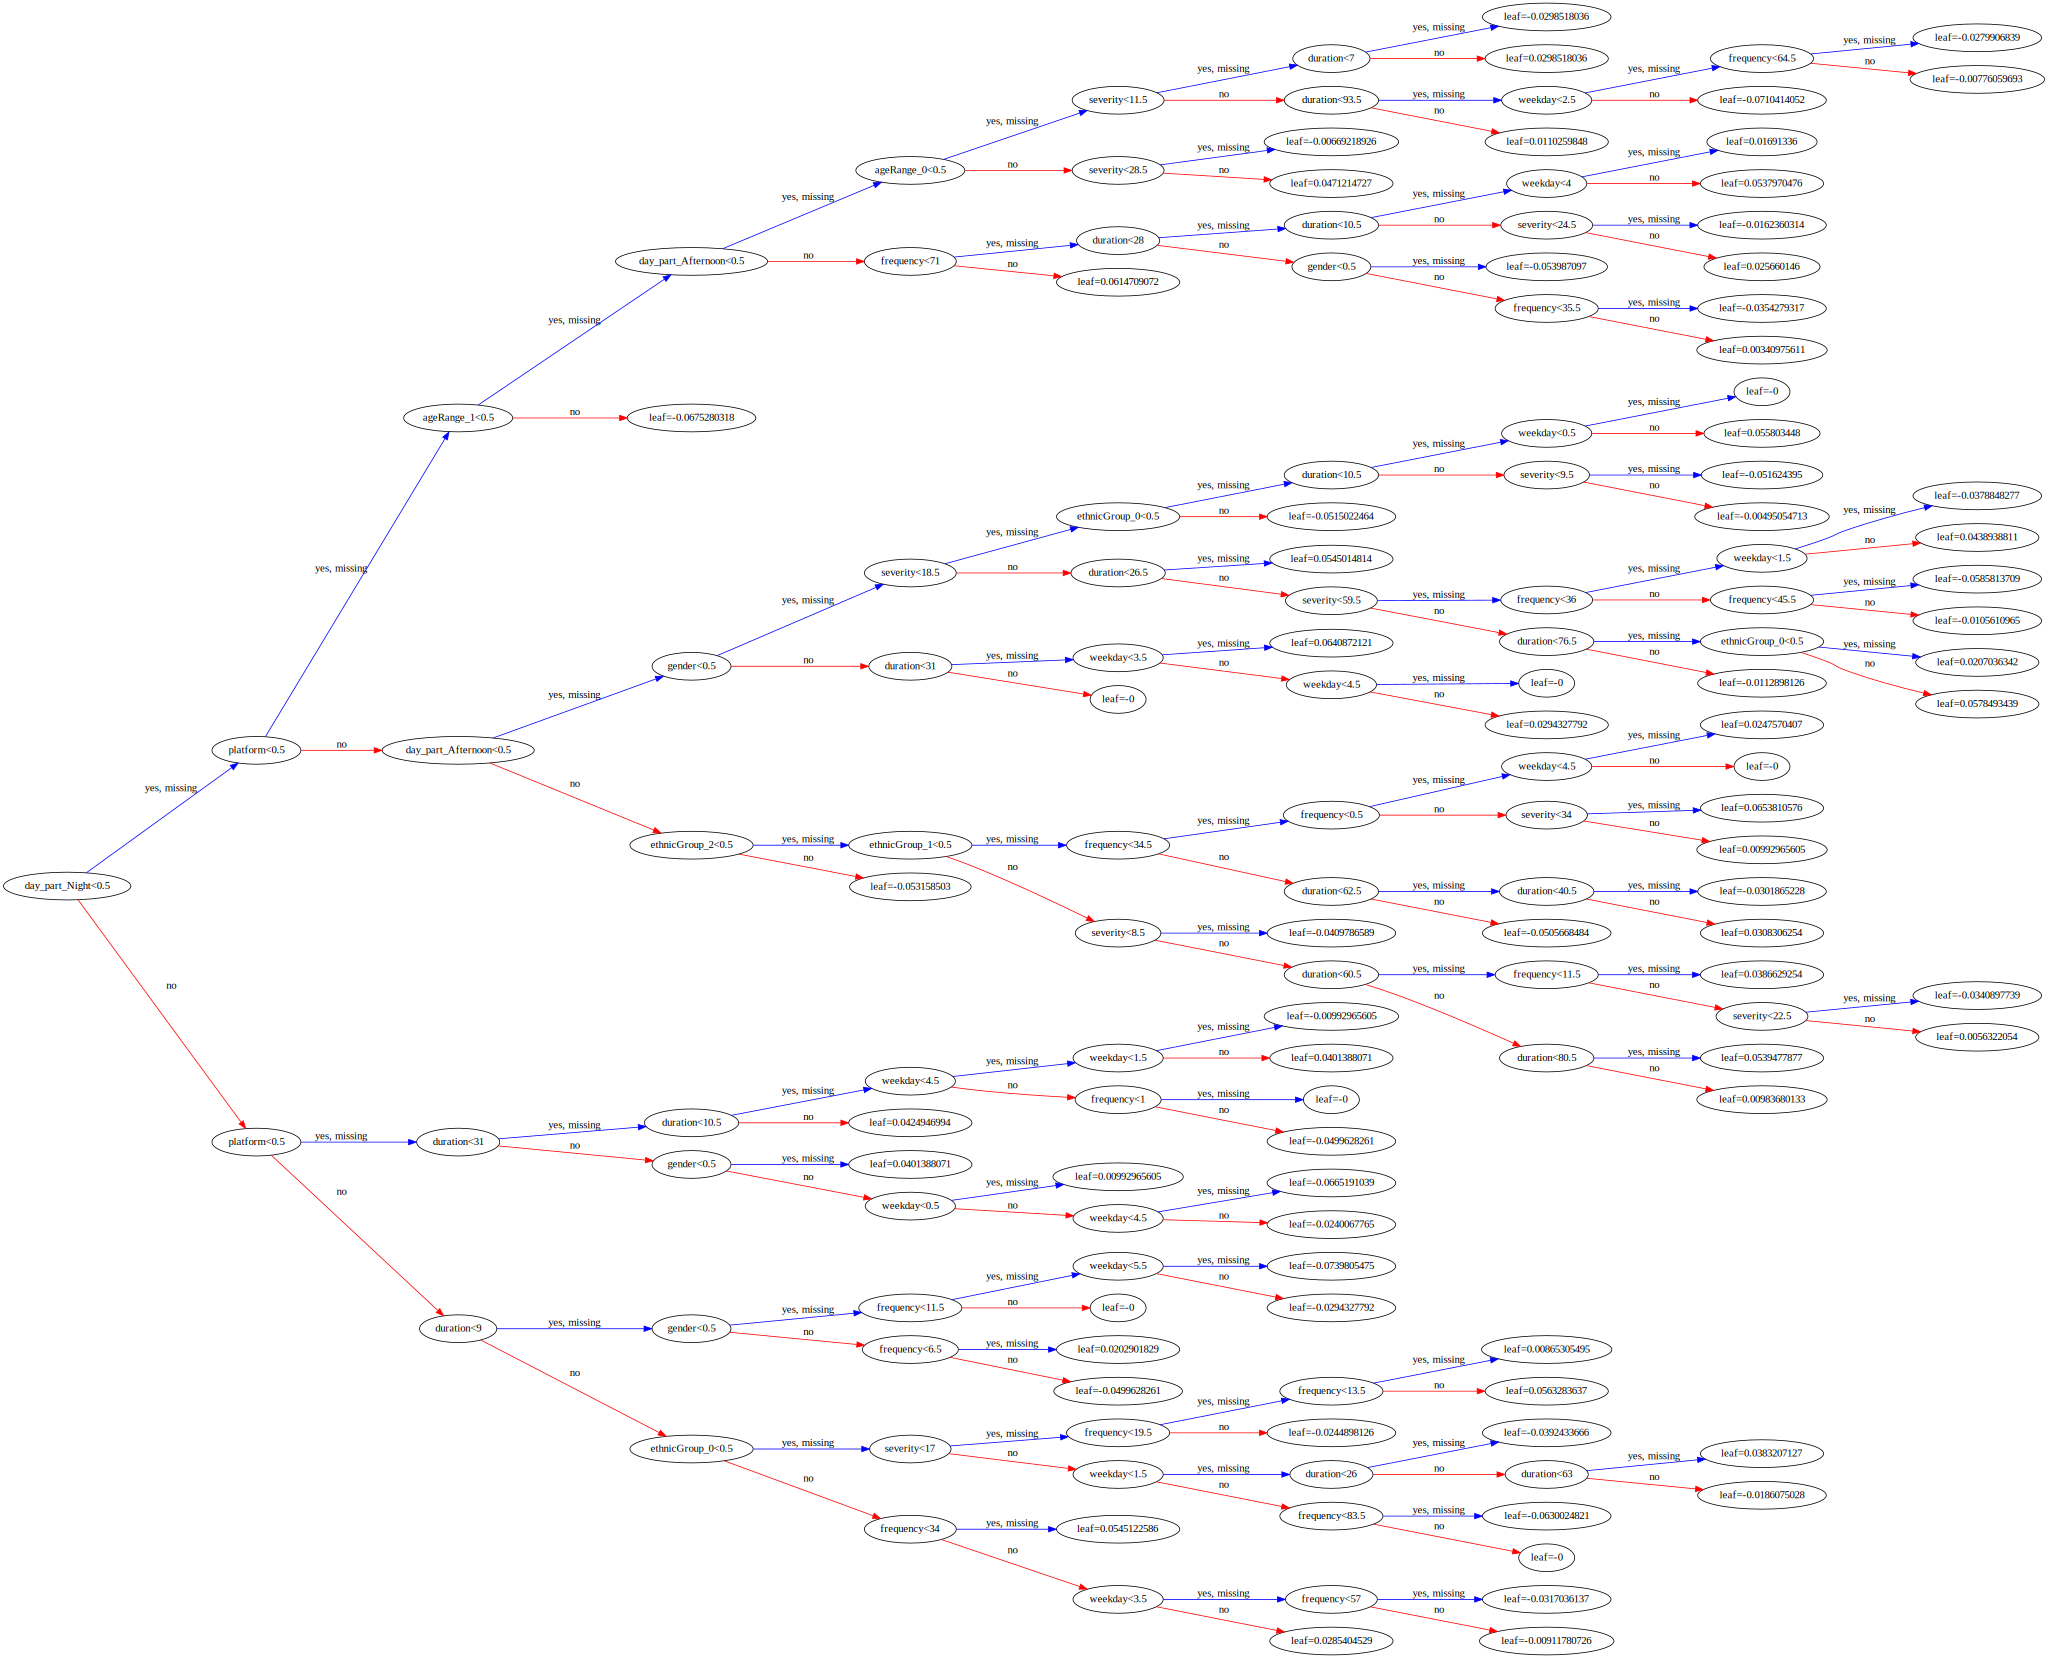

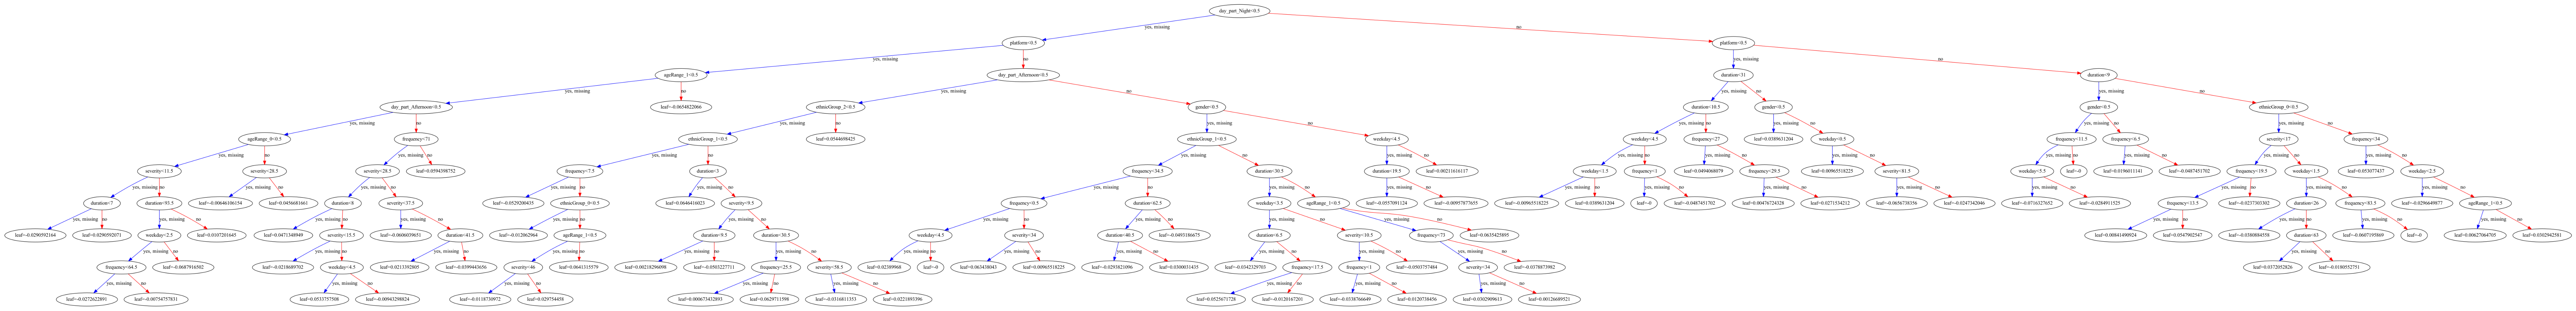

In [17]:
fig, ax = plt.subplots(figsize=(100, 100))
xgb.plot_tree(model, num_trees=5, ax=ax)
plt.savefig("xgb_tree.png")
# Get a graph
# graph = xgb.to_graphviz(model, num_trees=1)
# # Or get a matplotlib axis
# ax = xgb.plot_tree(model)
# Get feature importances
# px.bar(model.feature_importances_)
xgb.to_graphviz(model, num_trees=4, rankdir='LR')

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

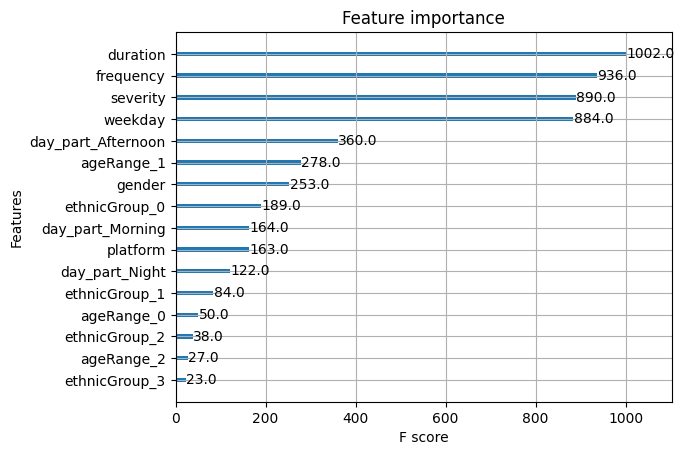

In [18]:
from xgboost import plot_importance
plot_importance(model)

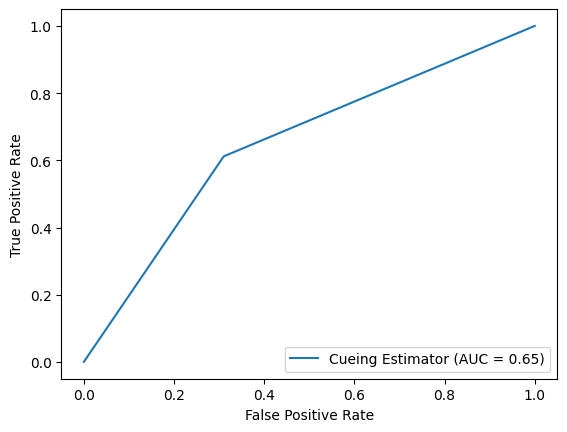

In [19]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)

roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Cueing Estimator')

display.plot()
plt.show()